# Exploratory Data Analysis (EDA) of Inter-Beat Interval (IBI) for High vs Low Stress

## Objective:
We aim to compare the Inter-Beat Interval (IBI) feature from Photoplethysmography (PPG) signals in high vs low stress conditions. This involves processing the PPG data, extracting IBI features, and visualizing the comparison using various plots.



In [11]:
import pandas as pd
import numpy as np
import heartpy as hp
import os
import matplotlib.pyplot as plt
import seaborn as sns  # For violin plot
from filtering import apply_filter  # Custom filter function

#### Listing and loading PPG data
a. Function to List CSV Files in Folders

In [12]:
def list_csv_files(filepath):
    abs_path = os.path.abspath(filepath)
    csv_files = [os.path.join(abs_path, f) for f in os.listdir(abs_path) if f.endswith('.csv')]
    return csv_files


b. Function to Load and Preprocess PPG Data
This function loads the CSV data and renames the columns. It returns the band100 values (PPG signal) for further processing.


In [13]:
def load_raw_data(filepath):
    df = pd.read_csv(filepath, header=0)
    df.columns = ['ref256', 'band100']
    return df['band100'].values


#### Data Processing for PPG Signals

a. Function to Process PPG File
This function filters the PPG signal and extracts the IBI feature using heartpy.

In [14]:
def process_ppg_file(filepath, sample_rate=100):
    try:
        ppg_signal = load_raw_data(filepath)
        ppg_signal_filt = apply_filter(signal=ppg_signal, filter_type='bandpass', cutoff=[0.7, 2.5], fs=100, order=3)
        working_data, measures = hp.process(ppg_signal_filt, sample_rate=sample_rate)
        return working_data, measures
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return None, None

b. Processing All Files
We process both high and low stress files and store the results in a list of dictionaries.

In [15]:
def process_files(file_list, file_type, sample_rate=100):
    results = []
    for file_path in file_list:
        wd, m = process_ppg_file(file_path, sample_rate)
        if wd and m:
            results.append({'filename': os.path.basename(file_path), 'working_data': wd, 'measures': m, 'file_type': file_type})
    return results

# List files and process them
filepaths_h = list_csv_files('../../ppg_data/High_MWL/')
filepaths_l = list_csv_files('../../ppg_data/Low_MWL/')
high_mwl_results = process_files(filepaths_h, 'high')
low_mwl_results = process_files(filepaths_l, 'low')
all_results = high_mwl_results + low_mwl_results


/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the pro

Error processing file /Users/ravirajpurohit/Downloads/Developer/ppg_data/Low_MWL/p10l.csv: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------



/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Error processing file /Users/ravirajpurohit/Downloads/Developer/ppg_data/Low_MWL/p4l.csv: Length mismatch: Expected axis has 5 elements, new values have 2 elements


/Users/ravirajpurohit/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


#### Visualizing Raw and Filtered PPG Signal for a Sample File

This helps us understand the difference between raw and filtered signals.

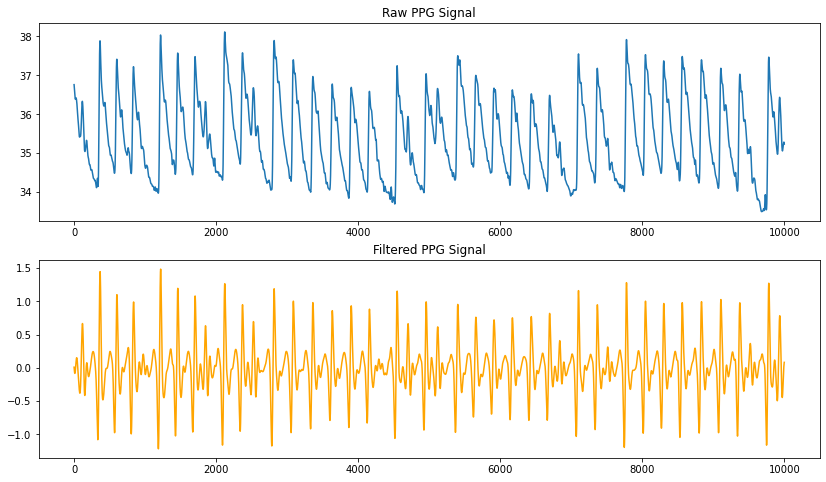

In [16]:
def plot_raw_vs_filtered(filepath):
    ppg_signal = load_raw_data(filepath)
    ppg_signal_filt = apply_filter(signal=ppg_signal, filter_type='bandpass', cutoff=[0.7, 2.5], fs=100, order=3)

    plt.figure(figsize=(14, 8))
    
    plt.subplot(211)
    plt.plot(ppg_signal[:10000], label='Raw Signal')
    plt.title('Raw PPG Signal')
    plt.subplot(212)
    plt.plot(ppg_signal_filt[:10000], label='Filtered Signal', color='orange')
    plt.title('Filtered PPG Signal')
    plt.show()

# Plot for an example high stress file
plot_raw_vs_filtered(filepaths_h[0])


#### IBI Feature Extraction and Visualization
a. Extracting IBI Data for High vs Low Stress

In [19]:
def extract_ibi_data(results):
    ibi_data = {'high': [], 'low': []}
    for result in results:
        ibi = result['measures'].get('ibi')
        if ibi:
            ibi_data[result['file_type']].append(ibi)
    return ibi_data

ibi_data = extract_ibi_data(all_results)


b. Visualizing IBI Comparison

i. Box Plot Comparison

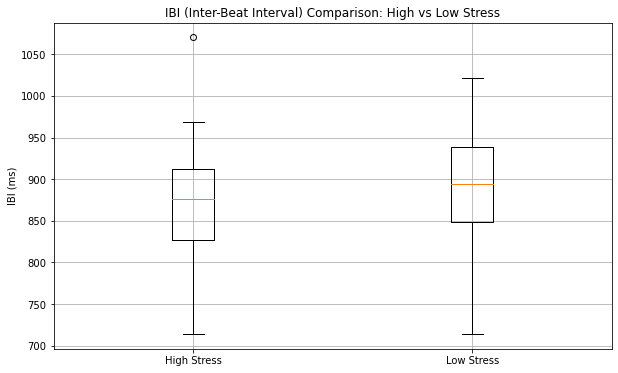

In [20]:
def plot_ibi_boxplot(ibi_data):
    data = [ibi_data['high'], ibi_data['low']]
    labels = ['High Stress', 'Low Stress']
    
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title('IBI (Inter-Beat Interval) Comparison: High vs Low Stress')
    plt.ylabel('IBI (ms)')
    plt.grid(True)
    plt.show()

plot_ibi_boxplot(ibi_data)


ii. Violin Plot for Distribution


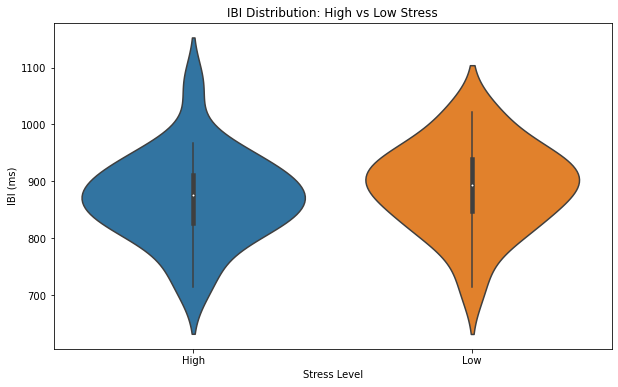

In [21]:
def plot_ibi_violin(ibi_data):
    ibi_df = pd.DataFrame({
        'IBI': ibi_data['high'] + ibi_data['low'],
        'Stress Level': ['High'] * len(ibi_data['high']) + ['Low'] * len(ibi_data['low'])
    })
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Stress Level', y='IBI', data=ibi_df)
    plt.title('IBI Distribution: High vs Low Stress')
    plt.ylabel('IBI (ms)')
    plt.show()

plot_ibi_violin(ibi_data)


iii. Line Plot for Sequential Comparison


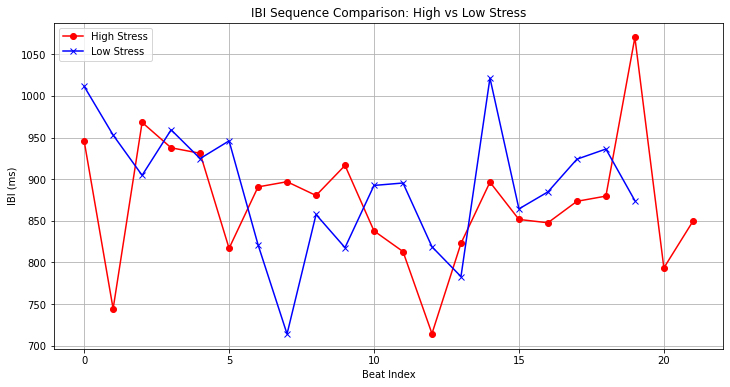

In [22]:
def plot_ibi_line(ibi_data):
    plt.figure(figsize=(12, 6))
    
    plt.plot(ibi_data['high'][:100], label='High Stress', color='red', marker='o')
    plt.plot(ibi_data['low'][:100], label='Low Stress', color='blue', marker='x')
    
    plt.title('IBI Sequence Comparison: High vs Low Stress')
    plt.ylabel('IBI (ms)')
    plt.xlabel('Beat Index')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ibi_line(ibi_data)
